# Training with Back-propagation Algorithms

Back-propagation (BP) trainings have become foundations in machine learning algorithms. In this section, we are going to talk about how to train models with BP.

In [1]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd
import numpy as np

bm.set_mode(bm.training_mode)
bm.set_platform('cpu')

bp.__version__

'2.3.1'

Here, we train two kinds of models to classify MNIST dataset. The first is ANN models commonly used in deep neural networks. The second is SNN models.

## Train a ANN model

We first build a three layer ANN model:

```bash

i >> r >> o
```

where the recurrent layer ``r`` is a LSTM cell, the output ``o`` is a linear readout.

In [2]:
class ANNModel(bp.dyn.DynamicalSystem):
    def __init__(self, num_in, num_rec, num_out):
        super(ANNModel, self).__init__()
        self.rec = bp.layers.LSTMCell(num_in, num_rec)
        self.out = bp.layers.Dense(num_rec, num_out)

    def update(self, sha, x):
        x = self.rec(sha, x)
        x = self.out(sha, x)
        return x

Before training this model, we get and clean the data we want.

In [3]:
root = r"D:\data"
train_dataset = bd.vision.FashionMNIST(root, split='train', download=True)
test_dataset = bd.vision.FashionMNIST(root, split='test', download=True)


def get_data(dataset, batch_size=256):
  rng = bm.random.clone_rng()

  def data_generator():
    X = bm.array(dataset.data, dtype=bm.float_) / 255
    Y = bm.array(dataset.targets, dtype=bm.float_)
    key = rng.split_key()
    rng.shuffle(X, key=key)
    rng.shuffle(Y, key=key)
    for i in range(0, len(dataset), batch_size):
      yield X[i: i + batch_size], Y[i: i + batch_size]

  return data_generator

Then, we start to train our defined ANN model with ``brainpy.train.BPTT`` training interface.

In [4]:
# model
model = ANNModel(28, 100, 10)

# loss function
def loss_fun(predicts, targets):
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(axis=-1) == targets)
    return loss, {'acc': acc}

# optimizer
optimizer=bp.optim.Adam(lr=1e-3)

# trainer
trainer = bp.train.BPTT(model,
                        loss_fun=loss_fun,
                        loss_has_aux=True,
                        optimizer=optimizer)

In [5]:
trainer.fit(train_data=get_data(train_dataset, 256),
            test_data=get_data(test_dataset, 512),
            num_epoch=10)

Train 0 epoch, use 11.7911 s, loss 0.9686446785926819, acc 0.657629668712616
Test 0 epoch, use 1.1449 s, loss 0.6075307726860046, acc 0.7804630398750305
Train 1 epoch, use 9.1454 s, loss 0.5276323556900024, acc 0.8128490447998047
Test 1 epoch, use 0.2927 s, loss 0.5302323698997498, acc 0.8131089210510254
Train 2 epoch, use 9.0979 s, loss 0.4588756263256073, acc 0.8355662226676941
Test 2 epoch, use 0.3037 s, loss 0.4678855538368225, acc 0.8310604095458984
Train 3 epoch, use 9.1892 s, loss 0.42316296696662903, acc 0.8461214303970337
Test 3 epoch, use 0.2911 s, loss 0.45249971747398376, acc 0.8364487886428833
Train 4 epoch, use 9.0769 s, loss 0.3961907625198364, acc 0.8553800582885742
Test 4 epoch, use 0.2947 s, loss 0.4217829704284668, acc 0.8458294868469238
Train 5 epoch, use 8.9839 s, loss 0.3784363567829132, acc 0.8621509075164795
Test 5 epoch, use 0.3015 s, loss 0.41539546847343445, acc 0.8533375859260559
Train 6 epoch, use 8.9756 s, loss 0.362664133310318, acc 0.8676861524581909
Tes

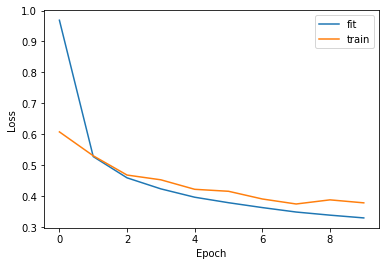

In [6]:
import matplotlib.pyplot as plt

plt.plot(trainer.get_hist_metric('fit'), label='fit')
plt.plot(trainer.get_hist_metric('test'), label='train')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train a SNN model

Similarly, ``brainpy.train.BPTT`` can also be used to train SNN models.

We first build a three layer SNN model:

```bash

i >> [exponential synapse] >> r >> [exponential synapse] >> o
```

In [7]:
class SNNModel(bp.dyn.DynamicalSystem):
  def __init__(self, num_in, num_rec, num_out):
    super(SNNModel, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out

    # neuron groups
    self.i = bp.neurons.InputGroup(num_in)
    self.r = bp.neurons.LIF(num_rec, tau=10, V_reset=0, V_rest=0, V_th=1.)
    self.o = bp.neurons.LeakyIntegrator(num_out, tau=5)

    # synapse: i->r
    self.i2r = bp.synapses.Exponential(self.i, self.r, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(),
                                       tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.))
    # synapse: r->o
    self.r2o = bp.synapses.Exponential(self.r, self.o, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(),
                                       tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.))

  def update(self, shared, spike):
    self.i2r(shared, spike)
    self.r2o(shared)
    self.r(shared)
    self.o(shared)
    return self.o.V.value

As the model receives spiking inputs, we define functions that are necessary to transform the continuous values to spiking data.

In [13]:
def current2firing_time(x, tau=20., thr=0.2, tmax=1.0, epsilon=1e-7):
  x = np.clip(x, thr + epsilon, 1e9)
  T = tau * np.log(x / (x - thr))
  T = np.where(x < thr, tmax, T)
  return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
  labels_ = np.array(y, dtype=bm.int_)
  sample_index = np.arange(len(X))

  # compute discrete firing times
  tau_eff = 2. / bm.get_dt()
  unit_numbers = np.arange(nb_units)
  firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=bm.int_)

  if shuffle:
    np.random.shuffle(sample_index)

  counter = 0
  number_of_batches = len(X) // batch_size
  while counter < number_of_batches:
    batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
    all_batch, all_times, all_units = [], [], []
    for bc, idx in enumerate(batch_index):
      c = firing_times[idx] < nb_steps
      times, units = firing_times[idx][c], unit_numbers[c]
      batch = bc * np.ones(len(times), dtype=bm.int_)
      all_batch.append(batch)
      all_times.append(times)
      all_units.append(units)
    all_batch = np.concatenate(all_batch).flatten()
    all_times = np.concatenate(all_times).flatten()
    all_units = np.concatenate(all_units).flatten()
    x_batch = bm.zeros((batch_size, nb_steps, nb_units))
    x_batch[all_batch, all_times, all_units] = 1.
    y_batch = bm.asarray(labels_[batch_index])
    yield x_batch, y_batch
    counter += 1

Now, we can define a BP trainer for this SNN model.

In [9]:
def loss_fun(predicts, targets):
    predicts, mon = predicts
    # L1 loss on total number of spikes
    l1_loss = 1e-5 * bm.sum(mon['r.spike'])
    # L2 loss on spikes per neuron
    l2_loss = 1e-5 * bm.mean(bm.sum(bm.sum(mon['r.spike'], axis=0), axis=0) ** 2)
    # predictions
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(-1) == targets)
    return loss + l2_loss + l1_loss, {'acc': acc}

model = SNNModel(num_in=28*28, num_rec=100, num_out=10)

trainer = bp.train.BPTT(
    model,
    loss_fun=loss_fun,
    loss_has_aux=True,
    optimizer=bp.optim.Adam(lr=1e-3),
    monitors={'r.spike': model.r.spike},
)

The training process is similar to that of the ANN model, instead of the data is generated by the sparse generator function we defined above.

In [14]:
x_train = bm.array(train_dataset.data, dtype=bm.float_) / 255
y_train = bm.array(train_dataset.targets, dtype=bm.int_)

trainer.fit(lambda: sparse_data_generator(x_train.reshape(x_train.shape[0], -1),
                                          y_train,
                                          batch_size=256,
                                          nb_steps=100,
                                          nb_units=28 * 28),
            num_epoch=10)

Train 0 epoch, use 56.6148 s, loss 10.524602890014648, acc 0.3441840410232544
Train 1 epoch, use 48.7201 s, loss 1.947080373764038, acc 0.4961271286010742
Train 2 epoch, use 50.2106 s, loss 1.5027152299880981, acc 0.5980067849159241
Train 3 epoch, use 53.0944 s, loss 1.371555209159851, acc 0.63353031873703
Train 4 epoch, use 54.2528 s, loss 1.294083833694458, acc 0.6476696133613586
Train 5 epoch, use 56.5207 s, loss 1.2385631799697876, acc 0.6586705446243286
Train 6 epoch, use 61.7909 s, loss 1.2144725322723389, acc 0.6649806499481201
Train 7 epoch, use 72.7359 s, loss 1.1915594339370728, acc 0.6712072491645813
Train 8 epoch, use 76.2446 s, loss 1.153993010520935, acc 0.6776843070983887
Train 9 epoch, use 79.4869 s, loss 1.1312021017074585, acc 0.682542085647583


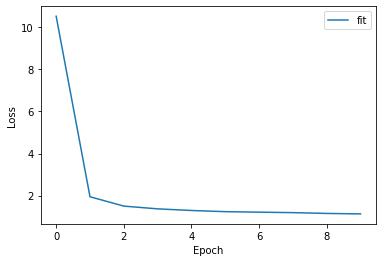

In [15]:
plt.plot(trainer.get_hist_metric('fit'), label='fit')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Customize your BP training

Actually, ``brainpy.train.BPTT`` is just one way to perform back-propagation training with your model. You can easily customize your training process.

In the below, we demonstrate how to define a BP training process by hand with the above ANN model.

In [16]:
# packages we need

from time import time

In [17]:
# define the model
model = ANNModel(28, 100, 10)

In [18]:
# define the loss function
@bm.to_object(child_objs=model)
def loss_fun(inputs, targets):
  runner = bp.train.DSTrainer(model, progress_bar=False, numpy_mon_after_run=False)
  predicts = runner.predict(inputs, reset_state=True)
  predicts = bm.max(predicts, axis=1)
  loss = bp.losses.cross_entropy_loss(predicts, targets)
  acc = bm.mean(predicts.argmax(-1) == targets)
  return loss, acc

In [19]:
# define the gradient function which computes the
# gradients of the trainable weights
grad_fun = bm.grad(loss_fun,
                   grad_vars=model.train_vars().unique(),
                   has_aux=True,
                   return_value=True)

In [20]:
# define the optimizer we need
opt = bp.optim.Adam(lr=1e-3, train_vars=model.train_vars().unique())

In [21]:
# training function

@bm.jit
@bm.to_object(child_objs=(opt, grad_fun))
def train(xs, ys):
  grads, loss, acc = grad_fun(xs, ys)
  opt.update(grads)
  return loss, acc

In [22]:
# start training

k = 0
num_batch = 256
running_loss = 0
running_acc = 0
print_step = 100
X_train = bm.asarray(x_train)
Y_train = bm.asarray(y_train)
t0 = time()
for _ in range(10):  # number of epoch
  X_train = bm.random.permutation(X_train, key=123)
  Y_train = bm.random.permutation(Y_train, key=123)

  for i in range(0, X_train.shape[0], num_batch):
    X = X_train[i: i + num_batch]
    Y = Y_train[i: i + num_batch]
    loss_, acc_ = train(X, Y)
    running_loss += loss_
    running_acc += acc_
    k += 1
    if k % print_step == 0:
      print('Step {}, Used {:.4f} s, Loss {:0.4f}, Acc {:0.4f}'.format(
        k, time() - t0,  running_loss / print_step, running_acc / print_step)
      )
      t0 = time()
      running_loss = 0
      running_acc = 0

Step 100, Used 6.7523 s, Loss 1.2503, Acc 0.5630
Step 200, Used 5.3020 s, Loss 0.6340, Acc 0.7779
Step 300, Used 6.5825 s, Loss 0.5545, Acc 0.8056
Step 400, Used 5.3013 s, Loss 0.5028, Acc 0.8198
Step 500, Used 5.3458 s, Loss 0.4659, Acc 0.8340
Step 600, Used 5.3190 s, Loss 0.4601, Acc 0.8316
Step 700, Used 5.2990 s, Loss 0.4297, Acc 0.8443
Step 800, Used 5.3577 s, Loss 0.4244, Acc 0.8456
Step 900, Used 5.3054 s, Loss 0.4053, Acc 0.8538
Step 1000, Used 5.3404 s, Loss 0.3913, Acc 0.8568
Step 1100, Used 5.2744 s, Loss 0.3943, Acc 0.8534
Step 1200, Used 5.4739 s, Loss 0.3863, Acc 0.8592
Step 1300, Used 5.4073 s, Loss 0.3709, Acc 0.8647
Step 1400, Used 5.3310 s, Loss 0.3791, Acc 0.8607
Step 1500, Used 5.3793 s, Loss 0.3644, Acc 0.8643
Step 1600, Used 5.3164 s, Loss 0.3562, Acc 0.8718
Step 1700, Used 5.4404 s, Loss 0.3585, Acc 0.8677
Step 1800, Used 5.4584 s, Loss 0.3533, Acc 0.8716
Step 1900, Used 5.4216 s, Loss 0.3460, Acc 0.8727
Step 2000, Used 5.4207 s, Loss 0.3445, Acc 0.8729
Step 2100